In [93]:
import csv
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator
from scipy.fft import fft, irfft, rfft, rfftfreq

# 1. Fourier Series Fit

### 1.1 Import Spec Data

In [4]:
spec_data_filename = 'spec_data_2024_03_12.csv'

spec_voltages = []
spec_frequencies = []

with open(spec_data_filename, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
    i = 0
    for row in reader:
        if i > 0:
            voltage = float(row[0])
            spec_voltages.append(voltage)
            frequency = float(row[1])
            spec_frequencies.append(frequency)
        i += 1
        
spec_voltages = np.array(spec_voltages)
spec_frequencies = np.array(spec_frequencies)

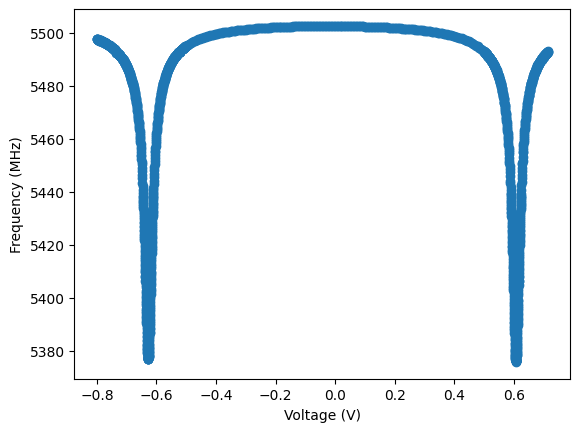

In [5]:
plt.plot(spec_voltages, spec_frequencies, linestyle='', marker='o')

plt.xlabel('Voltage (V)')
plt.ylabel('Frequency (MHz)')

plt.show()

### 1.2 Define Fit Function

In [193]:
def fourier_fit(x, *args):
    omega = args[0]
    a0 = args[1]
    phase = args[2]
    global_factor = args[3]
    
    cos_sin_sum = 0
    
    for i in range(1, (len(args) - 1)//2):
        cos_sin_sum += args[2*i + 2] * np.cos(i*omega*(x - phase))
        cos_sin_sum += args[2*i + 3] * np.sin(i*omega*(x - phase))        
        
    result = a0 + global_factor * cos_sin_sum
        
    return result

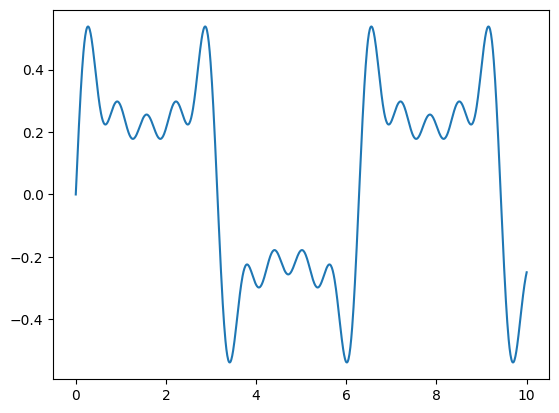

In [194]:
args = [1, 0, 0, 1] + [0, 1/3, 0, 0, 0, 1/5, 0, 0, 0, 1/7, 0, 0, 0, 1/9, 0, 0, 0, 1/11]

x = np.linspace(0, 10, 1001)
y = fourier_fit(x, *args)

plt.plot(x, y)

### 1.3 Fourier Transform for initial guess

In [265]:
### first interpolate data

spline = PchipInterpolator(spec_voltages, spec_frequencies)
# spline = Akima1DInterpolator(new_data_voltages, new_data_center_frequencies)

start_voltage = np.min(spec_voltages)
end_voltage = np.max(spec_voltages)

spline_voltages = np.linspace(start_voltage, end_voltage, 1001)
spline_frequencies = spline(spline_voltages)

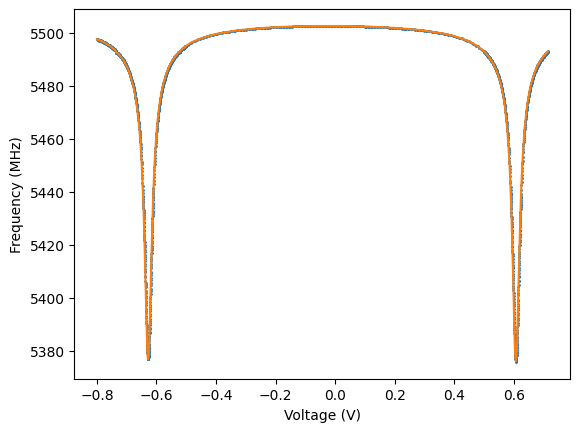

In [266]:
plt.plot(spec_voltages, spec_frequencies, linestyle='', ms=1, marker='o', label='data')
plt.plot(spline_voltages, spline_frequencies, label='interpolation')

plt.xlabel('Voltage (V)')
plt.ylabel('Frequency (MHz)')

plt.show()

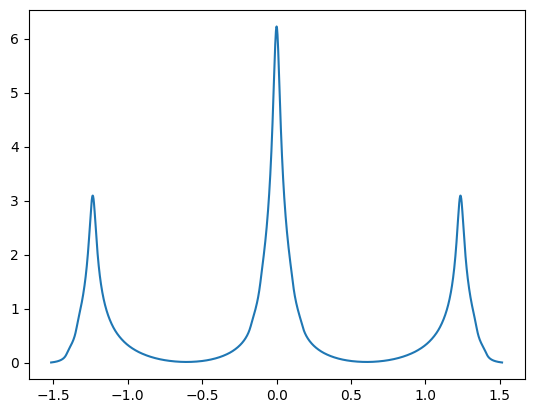

In [291]:
# autocorrelation to find period

spline_frequencies_offset = spline_frequencies - np.max(spline_frequencies)
autocorrelation = np.correlate(spline_frequencies_offset, spline_frequencies_offset, mode='full')/1e5

interpolation_voltage_spacing = spline_voltages[1] - spline_voltages[0]
interpolation_max_voltage_spacing = spline_voltages[-1] - spline_voltages[0]
autocorrelation_voltages = np.linspace(-interpolation_max_voltage_spacing, interpolation_max_voltage_spacing, 2*len(spline_voltages)-1)

plt.plot(autocorrelation_voltages, autocorrelation)
# plt.axvline(autocorrelation_voltages[left_peak_index])
# plt.axvline(autocorrelation_voltages[right_peak_index])
plt.show()

In [302]:
# period found from smaller peaks

print(len(autocorrelation_voltages))

left_peak_index = np.argmax(autocorrelation[:500])
right_peak_index = np.argmax(autocorrelation[1500:]) + 1500

print(autocorrelation_voltages[left_peak_index])
print(autocorrelation_voltages[right_peak_index])

voltage_period = abs(autocorrelation_voltages[right_peak_index])

2001
-1.23624
1.23624


In [381]:
# find number of samples within one voltage period

number_of_samples_per_period = round(voltage_period/interpolation_voltage_spacing)

1001
816


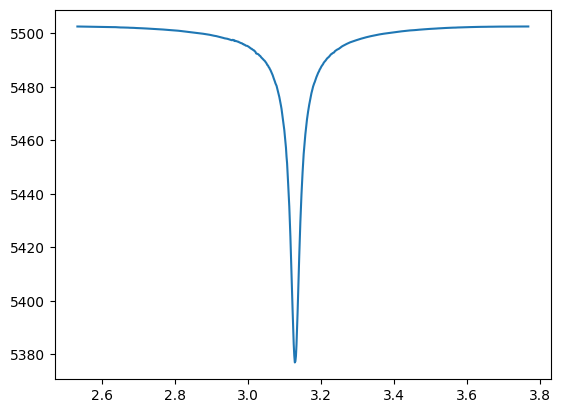

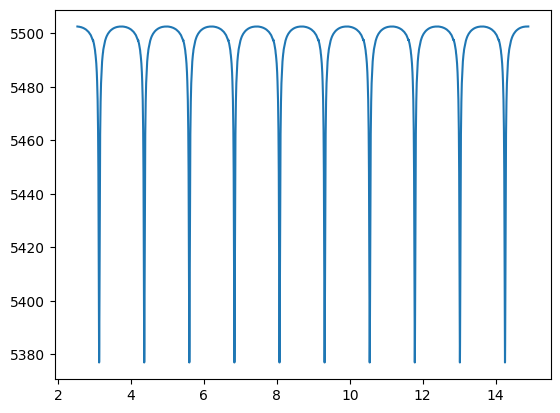

In [404]:
# tile spec data so that it is an integer number of periods

print(len(spline_frequencies))
print(number_of_samples_per_period)

# shift start by start index, elements before start index are reintroduced at the end of the array
start_index = 280

spec_frequencies_one_period = spline_frequencies[:number_of_samples_per_period]
spec_frequencies_one_period = np.roll(spec_frequencies_one_period, start_index)

spec_voltages_one_period = spline_voltages[:number_of_samples_per_period]
# start_voltage = spec_voltages_one_period[0] + start_index*interpolation_voltage_spacing
# end_voltage = spec_voltages_one_period[-1] + start_index*interpolation_voltage_spacing
# spec_voltages_one_period = np.arange(start_voltage, end_voltage, interpolation_voltage_spacing)
spec_voltages_one_period += start_index*interpolation_voltage_spacing

plt.plot(spec_voltages_one_period, spec_frequencies_one_period)
plt.show()

num_periods = 10

spec_frequencies_repeated = np.tile(spec_frequencies_one_period, num_periods)
# spec_frequencies_repeated = np.tile(spec_frequencies_one_period, num_period

start_voltage = spec_voltages_one_period[0]
end_voltage = start_voltage + (spec_voltages_one_period[-1] - start_voltage + interpolation_voltage_spacing)*num_periods
spec_voltages_repeated = np.arange(start_voltage, end_voltage, interpolation_voltage_spacing)

plt.plot(spec_voltages_repeated, spec_frequencies_repeated)

# plt.xlim(0.4, 0.6)

In [405]:
# fourier transform of spec data

num_points = len(spec_voltages_repeated)

sample_spacing = spec_voltages_repeated[1] - spec_voltages_repeated[0]


spec_data_fft = rfft(spec_frequencies_repeated)
freqs_fft = rfftfreq(num_points, sample_spacing)



In [406]:
# The maximum frequency is half the sample rate
points_per_freq = len(freqs_fft) * sample_spacing * 2 / 1000

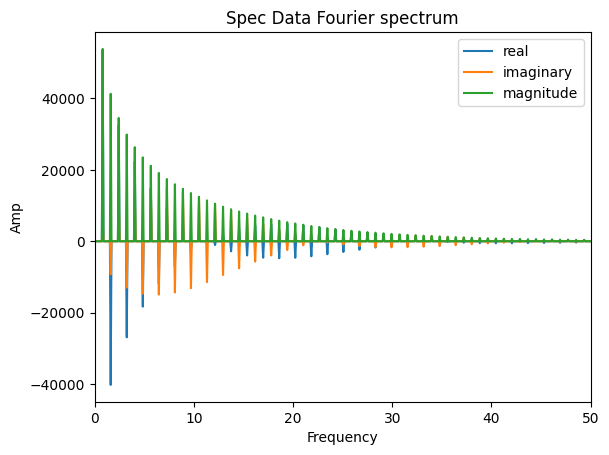

In [407]:
num_freq_points = spec_data_fft.shape[0]


spec_data_norm = 2.0/num_points * np.abs(spec_data_fft[1:])
spec_data_norm = spec_data_fft[1:]
freqs_no_dc = freqs_fft[1:]

spec_data_real = spec_data_norm.real
spec_data_imgainary = spec_data_norm.imag
spec_data_magnitude = np.abs(spec_data_norm)

# separate real and imaginary part


plt.plot(freqs_no_dc, spec_data_real, label='real')
plt.plot(freqs_no_dc, spec_data_imgainary, label='imaginary')
plt.plot(freqs_no_dc, spec_data_magnitude, label='magnitude')

plt.xlabel('Frequency')
plt.ylabel('Amp')
plt.title('Spec Data Fourier spectrum')

plt.xlim(0, 50)

plt.legend()

plt.show()

In [408]:
### find location of each peak

window_width = 3 

# don't include peaks smaller than threshold
threshold = 1

peak_freqs = []
peak_amps = []

for i in range(len(spec_data_magnitude) - window_width):
    left_edge = i
    right_edge = i + window_width
    
    peak = False
    
    for j in range(left_edge, right_edge):
        if spec_data_magnitude[j] > spec_data_magnitude[left_edge] and spec_data_magnitude[j] > spec_data_magnitude[right_edge-1]:
            peak = True
#             print(f'left: {spec_data_norm[left_edge]}')
#             print(f'right: {spec_data_norm[right_edge]}')
#             print(f'center: {spec_data_norm[j]}')
            
    if peak:
        peak_index = np.argmax(spec_data_magnitude[left_edge:right_edge]) + left_edge
#         print(f'peak_index: {peak_index}')
#         print(f'adding freq {freqs_no_dc[peak_index]}')
        peak_amp = spec_data_magnitude[peak_index]
        if peak_amp > threshold:
            peak_freqs.append(freqs_no_dc[peak_index])
            peak_amps.append(peak_amp)
        
    

In [409]:
# print(peak_freqs)
print(len(peak_freqs))

406


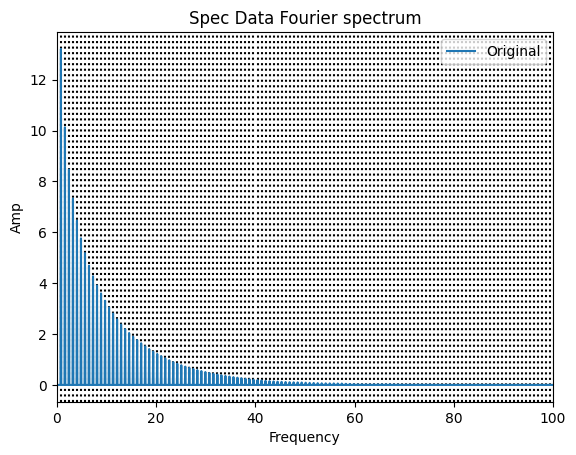

In [483]:
for peak_freq in peak_freqs:
    plt.axvline(peak_freq, linestyle=':', color='black')
    
for i in range(10):
    pass
    
plt.plot(freqs_no_dc, 2.0/num_points * np.abs(spec_data_norm), label='Original')
plt.xlabel('Frequency')
plt.ylabel('Amp')
plt.title('Spec Data Fourier spectrum')

plt.xlim(0, 100)

plt.legend()

plt.show()

### 1.4 Curve Fit

In [530]:
order = 50

#[fundamental frequency, dc offset, phase offset, global factor] + [cos coeff 1, sin coeff 1] + [cos coeff 2, sin coeff 2] + ...
fourier_initial_guess = [5, 5450, 0.6, -3] + [100, 0]*order
fourier_initial_guess = [5, 5480, 0.6, -5e-4]

for i in range(order):
    fourier_initial_guess += [peak_amps[i], 0]



print(fourier_initial_guess)

[5, 5480, 0.6, -0.0005, 53889.848536115154, 0, 41322.826912309196, 0, 34544.250709613676, 0, 29892.849231359043, 0, 26353.928381978123, 0, 23506.04963551753, 0, 21146.255462547597, 0, 19133.34748947111, 0, 17433.571806823427, 0, 15964.732682166483, 0, 14676.473633713103, 0, 13509.831449701263, 0, 12443.64499485631, 0, 11450.081461268364, 0, 10522.98687591123, 0, 9689.041993279347, 0, 8964.67164313013, 0, 8328.86179952796, 0, 7737.6904816649785, 0, 7183.0543418289335, 0, 6684.323478068141, 0, 6206.29699215248, 0, 5754.161225323268, 0, 5341.027121217962, 0, 4964.386104615258, 0, 4620.266726830434, 0, 4266.783551431414, 0, 3959.7838565901093, 0, 3666.4266914663435, 0, 3397.9207783821844, 0, 3157.3859682435004, 0, 2934.182322463382, 0, 2742.1776652307594, 0, 2562.417859867994, 0, 2383.24290660054, 0, 2224.8067049700926, 0, 2068.822043926618, 0, 1923.7187054169744, 0, 1791.926982475699, 0, 1665.7858643560453, 0, 1553.1741200761987, 0, 1443.9484297250633, 0, 1350.665932595416, 0, 1256.113909

In [531]:
print(spec_voltages)
print(fourier_fit(spec_voltages, *fourier_initial_guess))

[-0.8    -0.7995 -0.799  ...  0.714   0.7145  0.715 ]
[5482.67357781 5482.60032911 5482.51833996 ... 5477.35609865 5477.53972087
 5477.71716756]


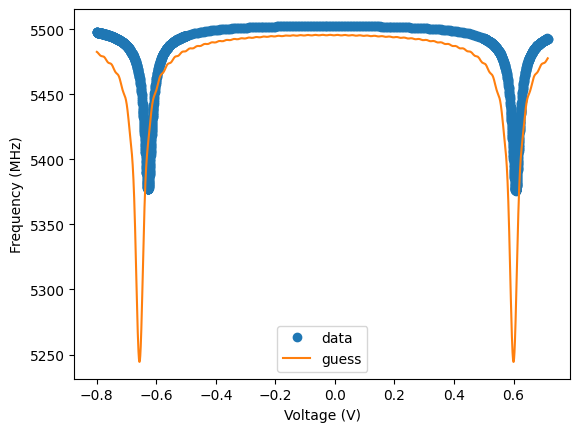

In [532]:
plt.plot(spec_voltages, spec_frequencies, linestyle='', marker='o', label='data')
plt.plot(spec_voltages, fourier_fit(spec_voltages, *fourier_initial_guess), label='guess')

plt.xlabel('Voltage (V)')
plt.ylabel('Frequency (MHz)')

plt.legend()

plt.show()

In [549]:
fourier_popt, pcov = curve_fit(fourier_fit, spec_voltages, spec_frequencies, p0=fourier_initial_guess)
print(fourier_popt)

[ 5.08486222e+00  5.49498386e+03  6.07579627e-01 -4.31283157e-04
  3.05953102e+04 -2.16731585e+02  2.34900510e+04 -3.11097731e+01
  1.96668432e+04  1.73582186e+00  1.70319490e+04 -1.70357987e+00
  1.50062014e+04  6.06545115e+00  1.33618593e+04  2.54066976e+00
  1.19990528e+04  2.91249616e+01  1.08488338e+04  4.64887533e+01
  9.89242902e+03  4.98760428e+01  9.07331768e+03  2.42475943e+01
  8.35491379e+03 -2.66344537e+00  7.69990513e+03 -2.07325139e+01
  7.10076911e+03 -1.13344002e+01  6.54750216e+03  2.18585731e+01
  6.03392780e+03  7.62052654e+01  5.56659802e+03  1.00872224e+02
  5.14470845e+03  9.19396860e+01  4.75438897e+03  5.72616699e+01
  4.38252447e+03  2.84246102e+01  4.04468668e+03  8.67047724e+00
  3.76738360e+03  1.22102639e+01  3.53056352e+03  3.43128169e+01
  3.31622135e+03  6.22900718e+01  3.10658809e+03  6.68005999e+01
  2.88267861e+03  6.04873210e+01  2.64807928e+03  5.35309243e+01
  2.40429552e+03  4.34607395e+01  2.21091127e+03  5.24717990e+01
  2.06588510e+03  3.73932

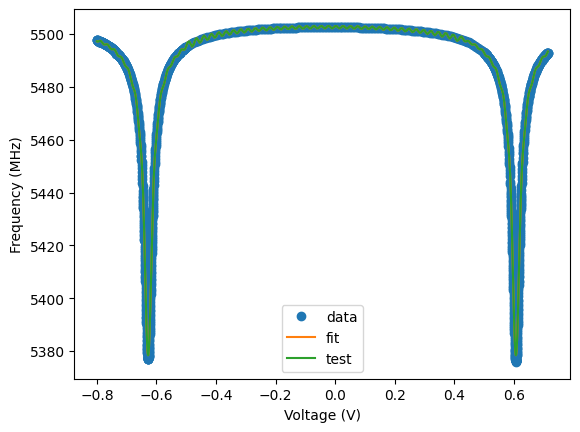

In [561]:
plt.plot(spec_voltages, spec_frequencies, linestyle='', marker='o', label='data')
# plt.plot(spec_voltages, fourier_fit(spec_voltages, *fourier_initial_guess), label='guess')
plt.plot(spec_voltages, fourier_fit(spec_voltages, *fourier_popt), label='fit')


test_popt = np.copy(fourier_popt)
# test_popt[5] = 10e3

plt.plot(spec_voltages, fourier_fit(spec_voltages, *test_popt), label='test')

plt.xlabel('Voltage (V)')
plt.ylabel('Frequency (MHz)')

plt.legend()

plt.show()

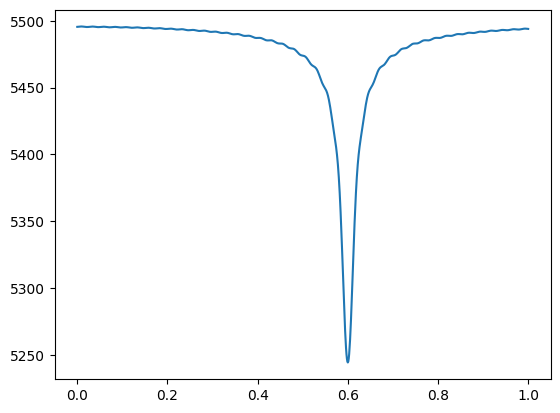

In [552]:
### x = np.linspace(0, 1, 1001)
plt.plot(x, fourier_fit(x, *fourier_initial_guess), label='guess')

plt.show()


### 1.5 Simple Fit
Don't include the fourier series coefficients as fit variables. Only keep the fundamental frequency, global offset, and x and y offsets.

In [536]:
simple_fourier_fit = lambda x, *args: fourier_fit(x, *args, *fourier_initial_guess[4:])

In [537]:
simple_fourier_initial_guess = [5, 5480, 0.6, -5e-4]
print(simple_fourier_initial_guess)

[5, 5480, 0.6, -0.0005]


In [538]:
print(simple_fourier_fit(spec_voltages, *simple_fourier_initial_guess))

[5482.67357781 5482.60032911 5482.51833996 ... 5477.35609865 5477.53972087
 5477.71716756]


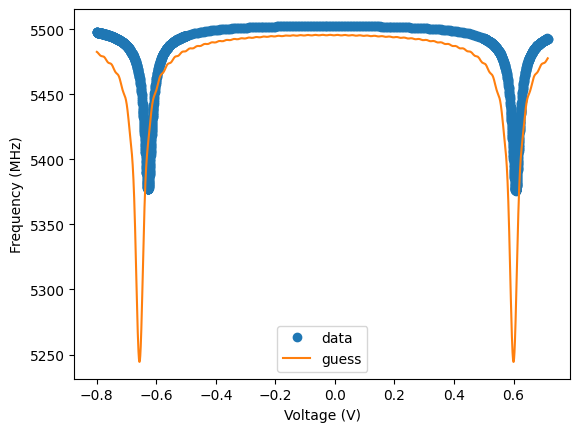

In [539]:
plt.plot(spec_voltages, spec_frequencies, linestyle='', marker='o', label='data')
plt.plot(spec_voltages, simple_fourier_fit(spec_voltages, *simple_fourier_initial_guess), label='guess')

plt.xlabel('Voltage (V)')
plt.ylabel('Frequency (MHz)')

plt.legend()

plt.show()

In [540]:
popt, pcov = curve_fit(simple_fourier_fit, spec_voltages, spec_frequencies, p0=simple_fourier_initial_guess)

IndexError: tuple index out of range

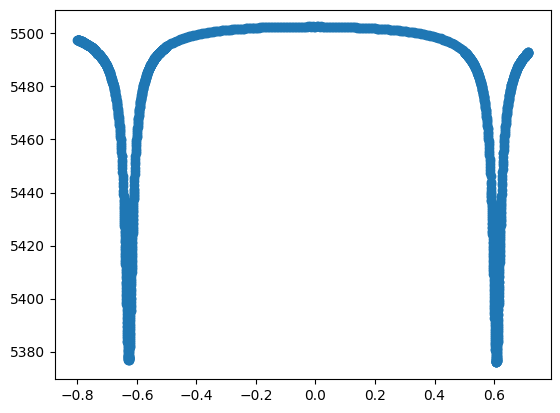

In [775]:
plt.plot(spec_voltages, spec_frequencies, linestyle='', marker='o', label='data', ms=6)
# plt.plot(spec_voltages, simple_fourier_fit(spec_voltages, *simple_fourier_initial_guess), label='guess')
plt.plot(spec_voltages, simple_fourier_fit(spec_voltages, *popt), label='fit', linewidth=2)

plt.xlabel('Voltage (V)')
plt.ylabel('Frequency (MHz)')

plt.xlim(-0.4, 0.4)
plt.ylim(5490, 5505)

plt.legend()

plt.show()

# 2. Polynomial Fit

### 2.1 Define Function

In [233]:
def polynomial_fit(x, *args):
    x0 = args[0]
    return sum([args[i]*np.power(x - x0, i-1) for i in range(1, len(args))])

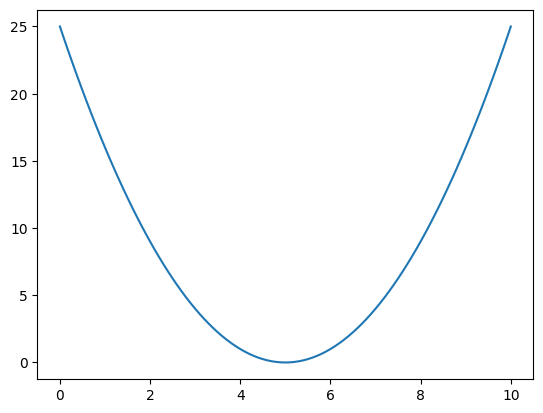

In [238]:
test_x = np.linspace(0, 10, 101)
test_args = [4, 1, -2, 1]
plt.plot(test_x, polynomial_fit(test_x, *test_args))
plt.show()

### 2.2 Taylor Series

In [240]:
center_voltage = 0

order = 5

coefficients = []

for i in range(order):
    pass

### 2.3 Curve Fit

In [562]:
order = 20
poly_initial_guess = [center_voltage, 5450] + [0, 1]*(order//2)
# initial_guess = [center_voltage, 5500, 0, -100, 0, 1, 0, 1]


print(initial_guess)

[5, 5480, 0.6, -0.0005]


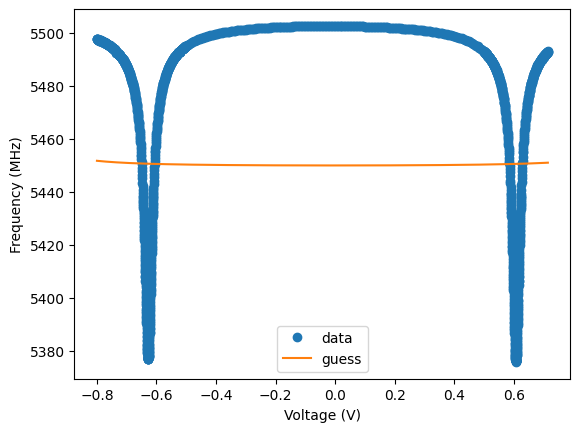

In [563]:
plt.plot(spec_voltages, spec_frequencies, linestyle='', marker='o', label='data')
plt.plot(spec_voltages, polynomial_fit(spec_voltages, *poly_initial_guess), label='guess')

plt.xlabel('Voltage (V)')
plt.ylabel('Frequency (MHz)')

plt.legend()

plt.show()

In [564]:
poly_popt, pcov = curve_fit(polynomial_fit, spec_voltages, spec_frequencies, p0=poly_initial_guess)

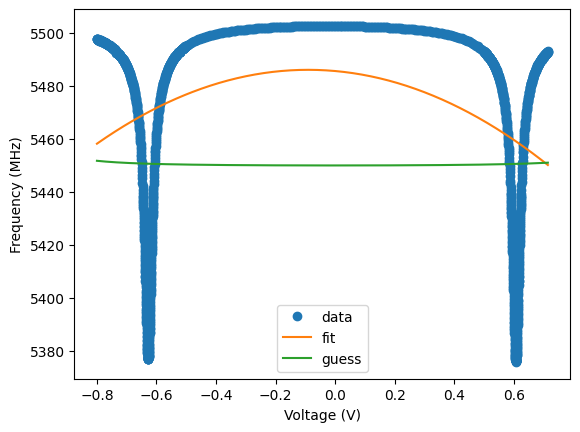

In [565]:
plt.plot(spec_voltages, spec_frequencies, linestyle='', marker='o', label='data')
plt.plot(spec_voltages, polynomial_fit(spec_voltages, *poly_popt), label='fit')
plt.plot(spec_voltages, polynomial_fit(spec_voltages, *poly_initial_guess), label='guess')

plt.xlabel('Voltage (V)')
plt.ylabel('Frequency (MHz)')

plt.legend()

plt.show()

# 3. Custom Fit

### 3.1 Custom Fit 1

In [949]:
def custom_fit_1(x, *args, function_type='cosine'):
    
    a, b, c, d, e = args[:5]

    if function_type == 'cosine':
        return a/(b+np.cos(c*(x-d)))+e    
    elif function_type == 'cosine squared':
        return a/(b+np.power(np.cos(c*(x-d)), 2))+e
    elif function_type == 'secant':
        return a/(b+1/np.cos(c*(x-d)))+e    
    elif function_type == 'cosine to alpha':
        return a/(b+np.power(np.abs(np.cos(c*(x-d))), args[-1]))+e
    elif function_type == '1 plus cosine to alpha':
        return a/(np.power(np.abs(b + np.cos(c*(x-d))), args[-1]))+e
    elif function_type == '1 plus cosine to beta to alpha':
        return a/(np.power(np.abs(b + np.power(np.abs(np.cos(c*(x-d))), args[-1])), args[-2]))+e

In [950]:
function_types = ['cosine', 'cosine squared', 'secant', 'cosine to alpha']

custom_1_initial_guesses = [[-5, 1.05, 5, 0, 5480],
                            [-10, 0.05, 2.5, 0, 5480],
                            [5, 0.95, 5, 0, 5480],
                            [5, 1.05, 5/1.5, 0, 5480, 2.5]]


function_types = ['1 plus cosine to alpha']
custom_1_initial_guesses = [[-0.8, 1.3, 5, 0, 5480, 4]]

function_types = ['1 plus cosine to beta to alpha']
custom_1_initial_guesses = [[-10, 0.01, 5/2, 0, 5480, 0.5, 1.5]]


print(custom_1_initial_guesses)

[[-10, 0.01, 2.5, 0, 5480, 0.5, 1.5]]


1 plus cosine to beta to alpha


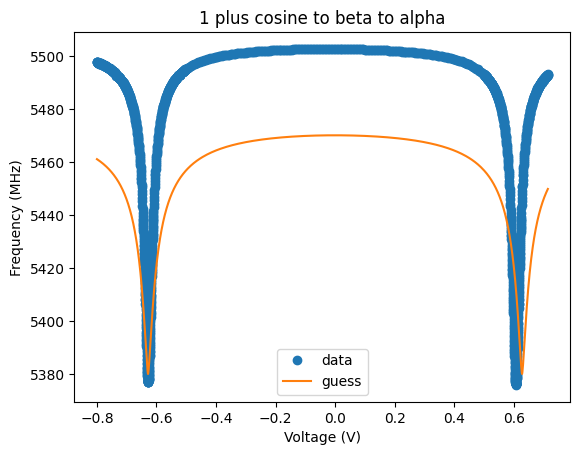

In [951]:
for i in range(len(function_types)):
    plt.plot(spec_voltages, spec_frequencies, linestyle='', marker='o', label='data')
    
    function_type = function_types[i]
    print(function_type)
    fit_function = lambda x, *args: custom_fit_1(x, *args, function_type=function_type)
    plt.plot(spec_voltages, fit_function(spec_voltages, *custom_1_initial_guesses[i]), label='guess')

    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (MHz)')
    
    plt.title(f'{function_type}')

    plt.legend()

    plt.show()

In [952]:
custom_1_popts = []
custom_1_pcovs = []

for i in range(len(function_types)):
    function_type = function_types[i]
    fit_function = lambda x, *args: custom_fit_1(x, *args, function_type=function_type)

    custom_popt, pcov = curve_fit(fit_function, spec_voltages, spec_frequencies, p0=custom_1_initial_guesses[i])
    custom_1_popts.append(custom_popt)
    custom_1_pcovs.append(pcov)
    print(custom_popt)

[-3.37279379e+00  2.02511685e-04  2.54241393e+00 -1.01658968e-02
  5.50554807e+03  4.27920822e-01  2.30194000e+00]


1 plus cosine to beta to alpha


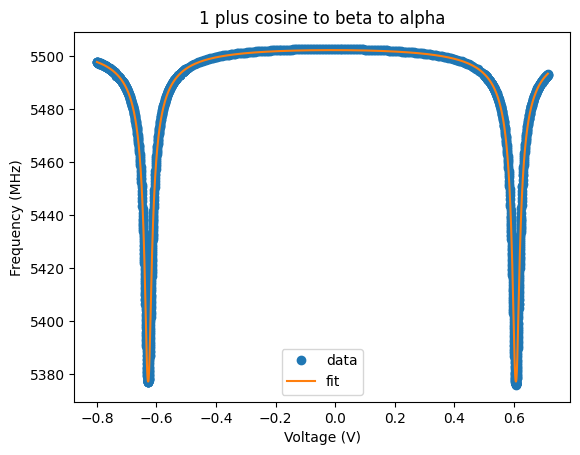

In [953]:
for i in range(len(function_types)):
    function_type = function_types[i]
    print(function_type)
    fit_function = lambda x, *args: custom_fit_1(x, *args, function_type=function_type)
    popt = custom_1_popts[i]
    
    plt.plot(spec_voltages, spec_frequencies, linestyle='', marker='o', label='data')
    plt.plot(spec_voltages, fit_function(spec_voltages, *popt), label='fit')
#     plt.plot(spec_voltages, fit_function(spec_voltages, *custom_1_initial_guesses[i]), label='guess')

    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (MHz)')

    plt.legend()
    plt.title(f'{function_type}')

    plt.show()

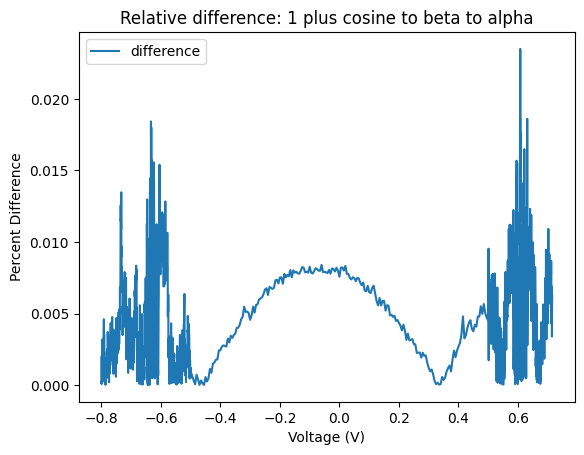

In [937]:
### plot differences

for i in range(len(function_types)):
    function_type = function_types[i]
    fit_function = lambda x, *args: custom_fit_1(x, *args, function_type=function_type)
    popt = custom_1_popts[i]

    plt.plot(spec_voltages, abs(fit_function(spec_voltages, *popt) - spec_frequencies)/spec_frequencies * 100, label='difference')

    plt.xlabel('Voltage (V)')
    plt.ylabel('Percent Difference')
    plt.title(f'Relative difference: {function_type}')

    plt.legend()

    plt.show()

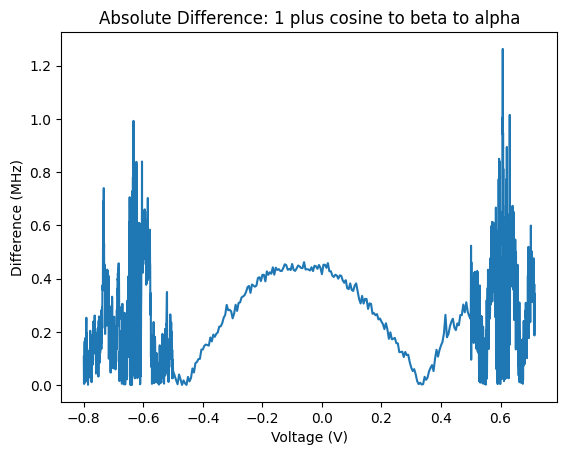

In [938]:
### plot absolute difference
for i in range(len(function_types)):
    function_type = function_types[i]
    fit_function = lambda x, *args: custom_fit_1(x, *args, function_type=function_type)
    popt = custom_1_popts[i]

    plt.plot(spec_voltages, abs(fit_function(spec_voltages, *popt) - spec_frequencies), label='difference')

    plt.xlabel('Voltage (V)')
    plt.ylabel('Difference (MHz)')

    plt.title(f'Absolute Difference: {function_type}')

    plt.show()

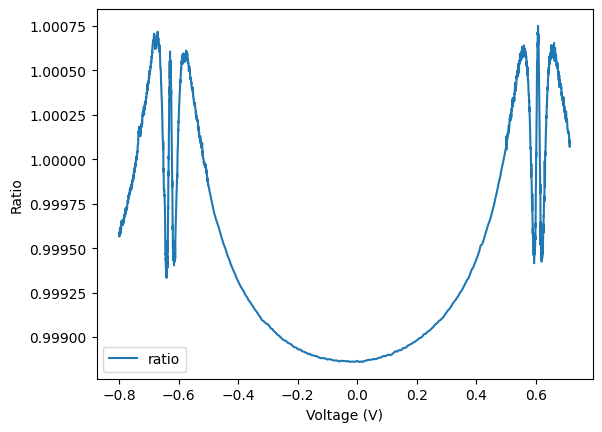

In [675]:
### plot ratio

plt.plot(spec_voltages, custom_fit_1(spec_voltages, *custom_popt)/spec_frequencies, label='ratio')

plt.xlabel('Voltage (V)')
plt.ylabel('Ratio')

plt.legend()

plt.show()

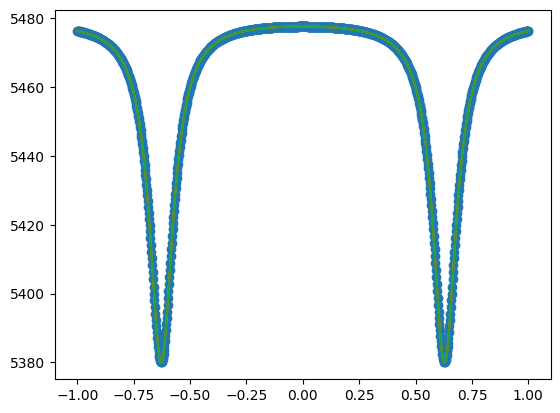

In [763]:
### check if the three functions are equivalent

x_test = np.linspace(-1, 1, 1001)
y_test = custom_fit_1(x_test, *custom_1_initial_guesses[0], 'cosine')

plt.plot(x_test, y_test, marker='o', linestyle='')

fit_function = lambda x, *args: custom_fit_1(x, *args, 'cosine squared')
popt_1_test, pcov = curve_fit(fit_function, x_test, y_test, p0=custom_1_initial_guesses[1])

plt.plot(x_test, fit_function(x_test, *popt_1_test), label='fit 1')

fit_function = lambda x, *args: custom_fit_1(x, *args, 'secant')
popt_2_test, pcov = curve_fit(fit_function, x_test, y_test, p0=custom_1_initial_guesses[2])

plt.plot(x_test, fit_function(x_test, *popt_2_test), label='fit 2')

plt.show()


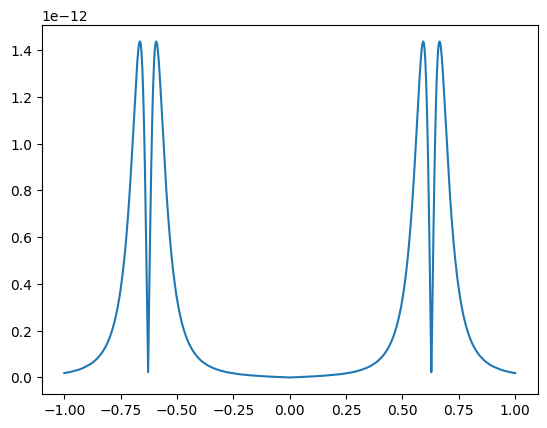

In [764]:
plt.plot(x_test, np.abs(fit_function(x_test, *popt_2_test) - y_test)/y_test)

### 3.2 Custom Fit 2

In [766]:
def custom_fit_2(x, a1, b1, a2, b2, c, d, e):
    result = a1/(b1+np.cos(c*(x-d))) + a2/(b2+np.cos(c*(x-d)))+e
    return result

In [767]:
custom_initial_guess = [-5, 1.05, -5, 1.05, 5, 0, 5480]

print(custom_initial_guess)

[-5, 1.05, -5, 1.05, 5, 0, 5480]


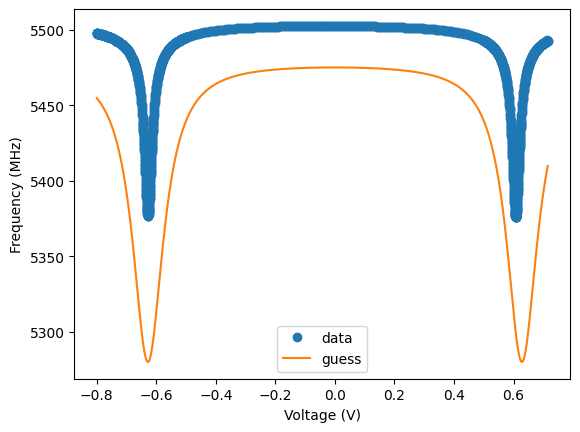

In [768]:
plt.plot(spec_voltages, spec_frequencies, linestyle='', marker='o', label='data')
plt.plot(spec_voltages, custom_fit_2(spec_voltages, *custom_initial_guess), label='guess')

plt.xlabel('Voltage (V)')
plt.ylabel('Frequency (MHz)')

plt.legend()

plt.show()

In [769]:
custom_popt, pcov = curve_fit(custom_fit_2, spec_voltages, spec_frequencies, p0=custom_initial_guess)
print(custom_popt)

[-3.05453925e-01  1.00283831e+00 -2.01127961e+00  1.10667425e+00
  5.08482868e+00 -1.01661472e-02  5.50321591e+03]


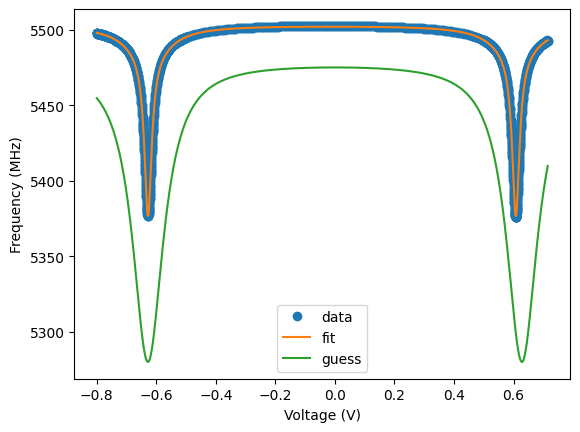

In [770]:
plt.plot(spec_voltages, spec_frequencies, linestyle='', marker='o', label='data')
plt.plot(spec_voltages, custom_fit_2(spec_voltages, *custom_popt), label='fit')
plt.plot(spec_voltages, custom_fit_2(spec_voltages, *custom_initial_guess), label='guess')

plt.xlabel('Voltage (V)')
plt.ylabel('Frequency (MHz)')

plt.legend()

plt.show()

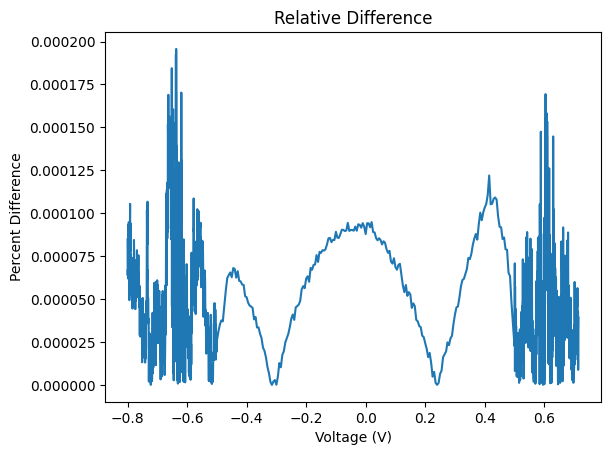

In [773]:
### plot relative difference

plt.plot(spec_voltages, abs(custom_fit_2(spec_voltages, *custom_popt) - spec_frequencies)/spec_frequencies)

plt.xlabel('Voltage (V)')
plt.ylabel('Percent Difference')

plt.title('Relative Difference')

plt.show()

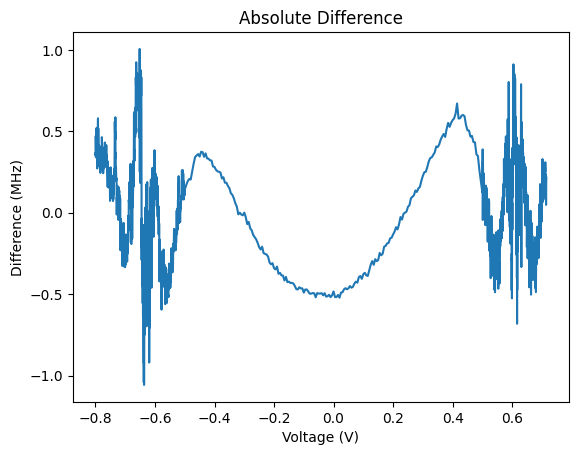

In [774]:
### plot absolute difference

plt.plot(spec_voltages, custom_fit_2(spec_voltages, *custom_popt) - spec_frequencies)

plt.xlabel('Voltage (V)')
plt.ylabel('Difference (MHz)')

plt.title('Absolute Difference')

plt.show()

### 3.3 Custom Fit 3
Sum N of the $\frac{1}{1+cos(x)}$ terms

In [682]:
def custom_fit_3(x, *args):
    c = args[0] # frequency
    d = args[1] # phase offset
    e = args[2] # vertical offset

    result = e
    for i in range((len(args) - 3)//2):
        ai = args[2*i + 3]
        bi = args[2*i + 4]
        result += ai/(bi+np.cos(c*(x-d)))
    
    return result 

In [694]:
order = 3
custom_initial_guess = [5, 0, 5480] + [-5, 1.05] * order 
custom_initial_guess[3] = -1
custom_initial_guess[4] = 1.01

print(custom_initial_guess)

[5, 0, 5480, -1, 1.01, -5, 1.05, -5, 1.05]


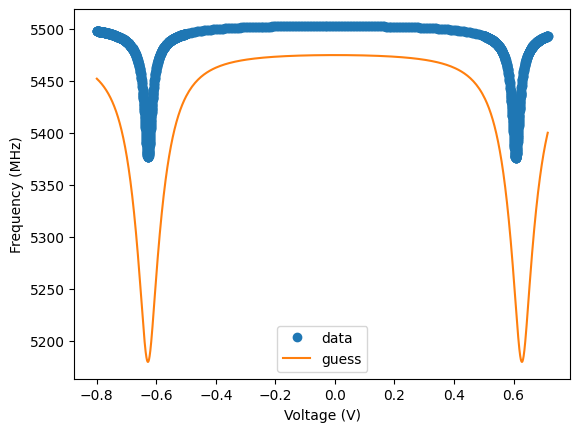

In [695]:
plt.plot(spec_voltages, spec_frequencies, linestyle='', marker='o', label='data')
plt.plot(spec_voltages, custom_fit_3(spec_voltages, *custom_initial_guess), label='guess')

plt.xlabel('Voltage (V)')
plt.ylabel('Frequency (MHz)')

plt.legend()

plt.show()

In [696]:
custom_popt, pcov = curve_fit(custom_fit_3, spec_voltages, spec_frequencies, p0=custom_initial_guess)
print(custom_popt)

[ 5.08482868e+00 -1.01661472e-02  5.50321595e+03 -3.05454783e-01
  1.00283832e+00 -6.75364069e+00  1.10667870e+00  4.74233823e+00
  1.10667992e+00]


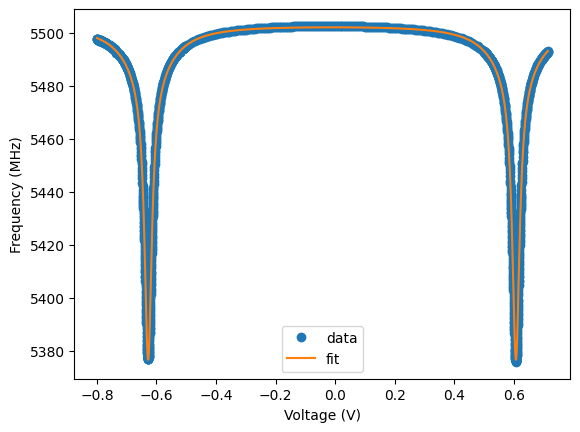

In [699]:
plt.plot(spec_voltages, spec_frequencies, linestyle='', marker='o', label='data')
plt.plot(spec_voltages, custom_fit_3(spec_voltages, *custom_popt), label='fit')
# plt.plot(spec_voltages, custom_fit_3(spec_voltages, *custom_initial_guess), label='guess')

plt.xlabel('Voltage (V)')
plt.ylabel('Frequency (MHz)')

plt.legend()

plt.show()

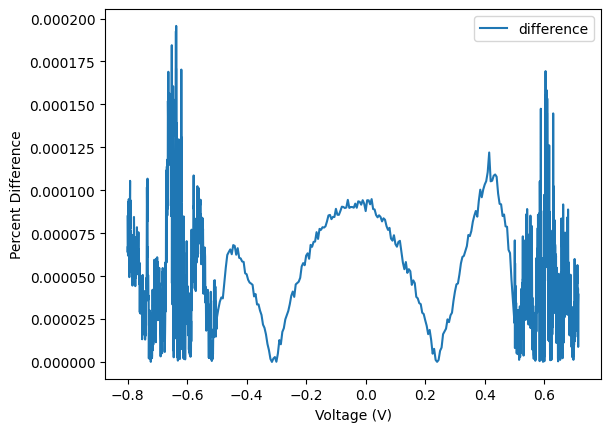

In [698]:
### plot difference

plt.plot(spec_voltages, abs(custom_fit_3(spec_voltages, *custom_popt) - spec_frequencies)/spec_frequencies, label='difference')

plt.xlabel('Voltage (V)')
plt.ylabel('Percent Difference')

plt.legend()

plt.show()